# Jupyter Notebook - Fake News Predictor
# Authors: `Alexander Burkhart, Jan Hery`

## A) Data Import

Import all of the required libraries and additional data we need for our predictive modelling task.

In [45]:
# Importing necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For data visualization
from wordcloud import WordCloud, STOPWORDS  # For creating word clouds
import nltk  # Natural Language Toolkit
from nltk.corpus import stopwords  # Stopwords for text processing
import re  # Regular expressions for text processing
import gensim  # For topic modeling and NLP
from gensim.utils import simple_preprocess  # Preprocessing for Gensim
from gensim.parsing.preprocessing import STOPWORDS  # Stopwords for Gensim
import nbformat # Reading and writing in notebooks
import plotly.express as px  # For interactive plots
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.feature_extraction.text import CountVectorizer  # For converting text data to numerical format
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import roc_auc_score  # ROC AUC score for model evaluation
from sklearn.metrics import confusion_matrix  # Confusion matrix for model evaluation

import tkinter as tk  # Import tkinter for GUI
from tkinter import Text, Label, Button, Scrollbar  # Specific imports from tkinter
from flask import Flask, render_template, request  # Import Flask for web development
import nltk  # Import NLTK for natural language processing
from nltk.corpus import stopwords  # Import NLTK's stopwords
from gensim.utils import simple_preprocess  # Import Gensim's text preprocessing function
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer for text-to-matrix conversion
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression for classification
from flask_ngrok import run_with_ngrok  # Import run_with_ngrok for exposing Flask app with ngrok

# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janhe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read both the data sets consisting of a data set with our `true` news article as well as `fake` news article.

In [46]:
# Use read_csv to read the two data sets
df_true = pd.read_csv("./dataset/True.csv")
df_fake = pd.read_csv("./dataset/Fake.csv")

Setting up a target variable with the name `target` and combining both the real and fake news datasets.

In [47]:
# Assign a 'target' column with value 1 to df_true indicating it is a true sample.
df_true['target'] = 1
# Assign a 'target' column with value 0 to df_fake indicating it is a fake sample.
df_fake['target'] = 0

# Concatenate df_true and df_fake DataFrames vertically, reset the index, and store the result in the variable df.
df = pd.concat([df_true, df_fake]).reset_index(drop=True)

# Create a new column 'original' in df by combining the 'title' and 'text' columns with a space in between.
df['original'] = df['title'] + ' ' + df['text']

# Display the first few rows of the resulting DataFrame df.
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

Check for null values for potential data cleaning. *Observation*: We don't have any kind of `NULL` values in our data set.

In [48]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

## B) Data Cleaning

Create a function that will be responsible to remove any unneccesary words (Stopwords) from the data provided. We will use this later in different approaches of our model training process.

In [49]:
# Importing the stopwords module from NLTK (Natural Language Toolkit)
stop_words = stopwords.words('english')

# Adding custom stopwords to the list
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Defining a function for text preprocessing
def preprocess(text):
    result = []  # Initialize an empty list to store preprocessed tokens
    
    # Iterate through tokens generated by Gensim's simple_preprocess
    for token in gensim.utils.simple_preprocess(text):
        # Check if the token is not in Gensim's predefined stopwords,
        # has a length greater than 2, and is not in the custom stop_words list
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)  # Append the token to the result list
    
    return result  # Return the list of preprocessed tokens

Group similar subjects together into one group, in this case `politics` and `politicNews`.

In [50]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

## C) Explorative Data Analysis (EDA)

Plot the distribtution of fake news compared to true news. *Observation*: The dataset appears to be well-balanced, simplifying our analysis. Therefore, there is no need to address imbalances, and we can confidently consider this dataset as balanced.

In [51]:
# Grouping the DataFrame 'df' by the 'target' column and counting the occurrences of 'title' for each group
sub_tf_df = df.groupby('target').apply(lambda x: x['title'].count()).reset_index(name='Counts')

# Replacing numerical values in the 'target' column with corresponding labels 'False' and 'True'
sub_tf_df.target.replace({0: 'False', 1: 'True'}, inplace=True)

# Creating a bar plot using Plotly Express with 'target' on the x-axis, 'Counts' on the y-axis, and colored by 'Counts'
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)

# Displaying the plot
fig.show()

Which categories or subjects are covered in the news? How is their distribution? *Observation*: Political News and World News hold the most domination counts in the data set that we have considered. We have to consider that we grouped two categories together when looking at Political News.

In [52]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

## D) Model Training, Prediction and Evaluation

### Approach I: Titles (Using the titles to predict the target of a news article)

In [53]:
# Applying the 'preprocess' function to the 'title' column of the DataFrame 'df' to clean and tokenize the text
df['clean_title'] = df['title'].apply(preprocess)

# Displaying the cleaned and tokenized title for the first rows in the 'clean_title' column
print(df['clean_title'].head())

# Creating a new column 'clean_joined_title' by joining the cleaned and tokenized words into a single string for each row
df['clean_joined_title'] = df['clean_title'].apply(lambda x: " ".join(x))

0    [budget, fight, looms, republicans, flip, fisc...
1    [military, accept, transgender, recruits, mond...
2     [senior, republican, senator, let, mueller, job]
3    [fbi, russia, probe, helped, australian, diplo...
4    [trump, wants, postal, service, charge, amazon...
Name: clean_title, dtype: object


Use `wordclouds` package to build word clouds with the words in news headlines from fake and true news.

**True News:**

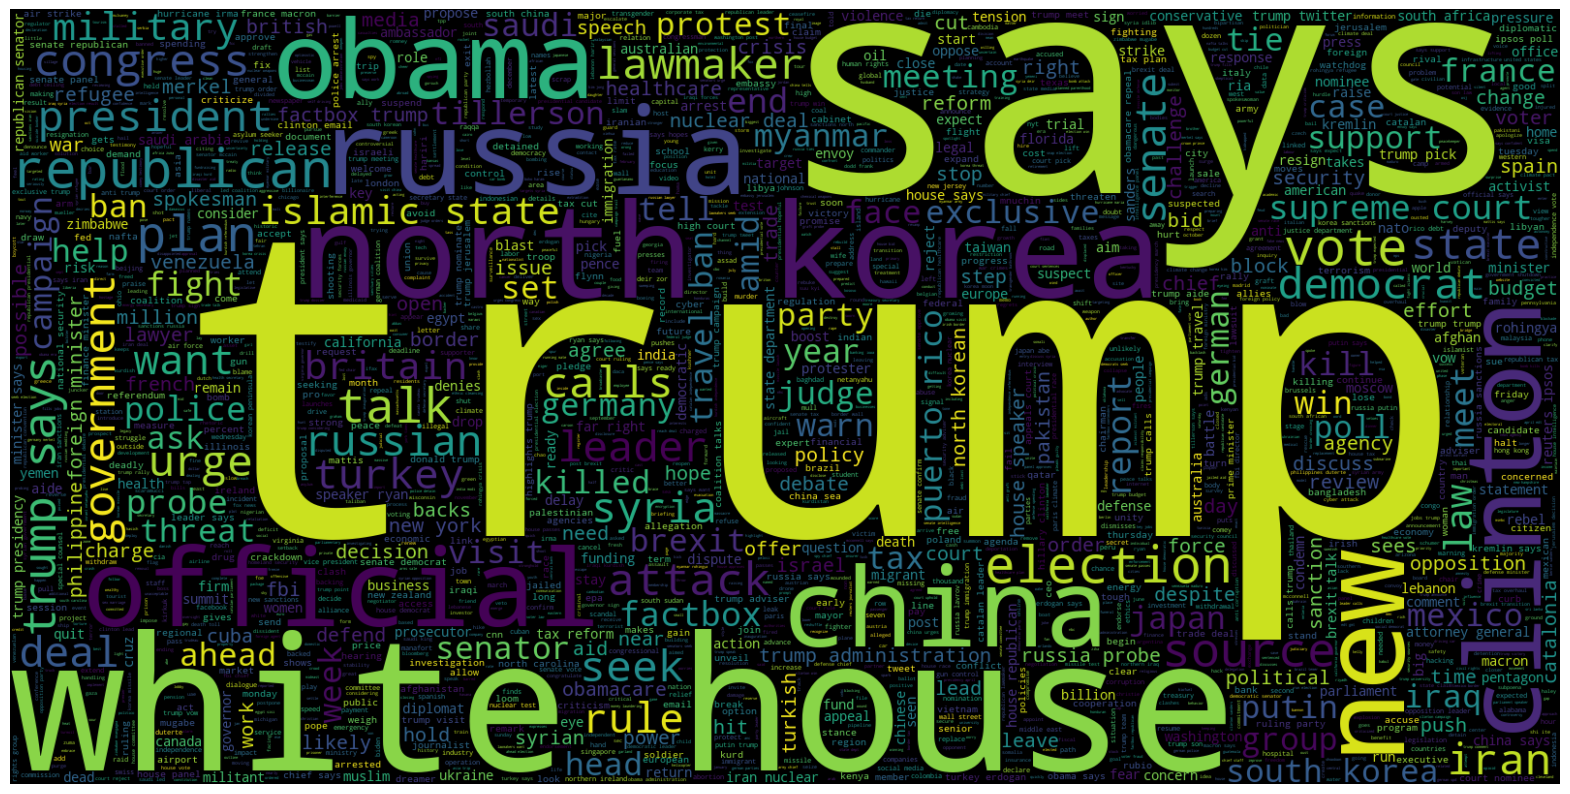

In [54]:
# Setting up the figure size for the word cloud visualization
plt.figure(figsize=(20, 20))

# Generating a word cloud for rows in the DataFrame where 'target' is equal to 1
wc_positive = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))

# Hiding the x and y axes
plt.axis('off')

# Removing ticks on the axes
plt.xticks([]), plt.yticks([])

# Displaying the word cloud using imshow with bilinear interpolation
plt.imshow(wc_positive, interpolation='bilinear')
plt.show()

**Fake News:**

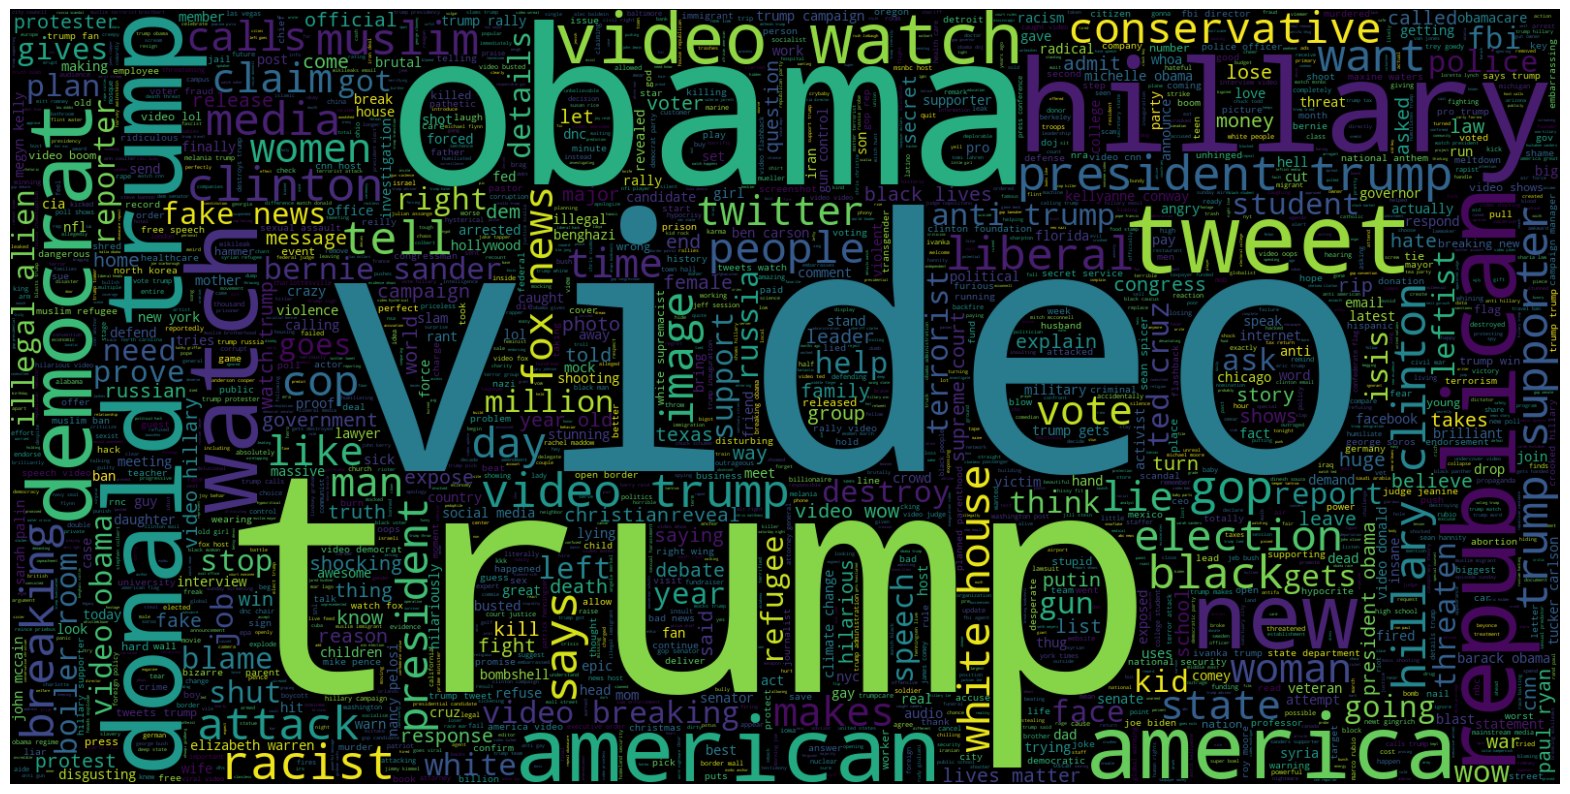

In [55]:
# Setting up the figure size for the word cloud visualization
plt.figure(figsize=(20, 20))

# Generating a word cloud for rows in the DataFrame where 'target' is equal to 1
wc_positive = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))

# Hiding the x and y axes
plt.axis('off')

# Removing ticks on the axes
plt.xticks([]), plt.yticks([])

# Displaying the word cloud using imshow with bilinear interpolation
plt.imshow(wc_positive, interpolation='bilinear')
plt.show()

In the following plot we print the number of words in a title and how often this number occurs. *Observation*: The longest title has 34 words and the title length that occurs the most (8,955 times) is with a length of 8 words.

In [56]:
# Initializing a variable to store the maximum number of words in a title
maxlen = -1

# Iterating through each document in the 'clean_joined_title' column of the DataFrame 'df'
for doc in df.clean_joined_title:
    # Tokenizing the document into words using NLTK's word_tokenize function
    tokens = nltk.word_tokenize(doc)
    
    # Updating maxlen if the number of tokens in the current document is greater
    if maxlen < len(tokens):
        maxlen = len(tokens)

# Displaying the maximum number of words found in any title
print("Maximum number of words in a title: ", maxlen)

# Creating a histogram using Plotly Express to visualize the distribution of word counts in titles
fig = px.histogram(x=[len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins=50)

# Displaying the histogram
fig.show()

Maximum number of words in a title:  34


Splitting the data set into testing and training.

In [57]:
# Train/ test split with in a 80/ 20 ratio
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train_1 = CountVectorizer().fit(X_train_1)
X_vec_train_1 = vec_train_1.transform(X_train_1)
X_vec_test_1 = vec_train_1.transform(X_test_1)

Prediction with Logistic Regression. *Observation*: The model based on Logistics performs extremely well with an accuracy of about 95%.

In [58]:
# Use LogisticRegression() as predictive modelling algorithm and fit model
model_1 = LogisticRegression(C=2, max_iter=1000)
model_1.fit(X_vec_train_1, y_train_1)

# Do the prediction
predicted_value = model_1.predict(X_vec_test_1)

# Get and print accuracy via "area under the curve" score
accuracy_value = roc_auc_score(y_test_1, predicted_value)
print(f"Accuracy Logistic Regression: {round(accuracy_value, 4)}")

Accuracy Logistic Regression: 0.9474


Show result in confusion matrix. *Observation*: In total we only missclassified 475 out of 8,980 news articles.

<Axes: >

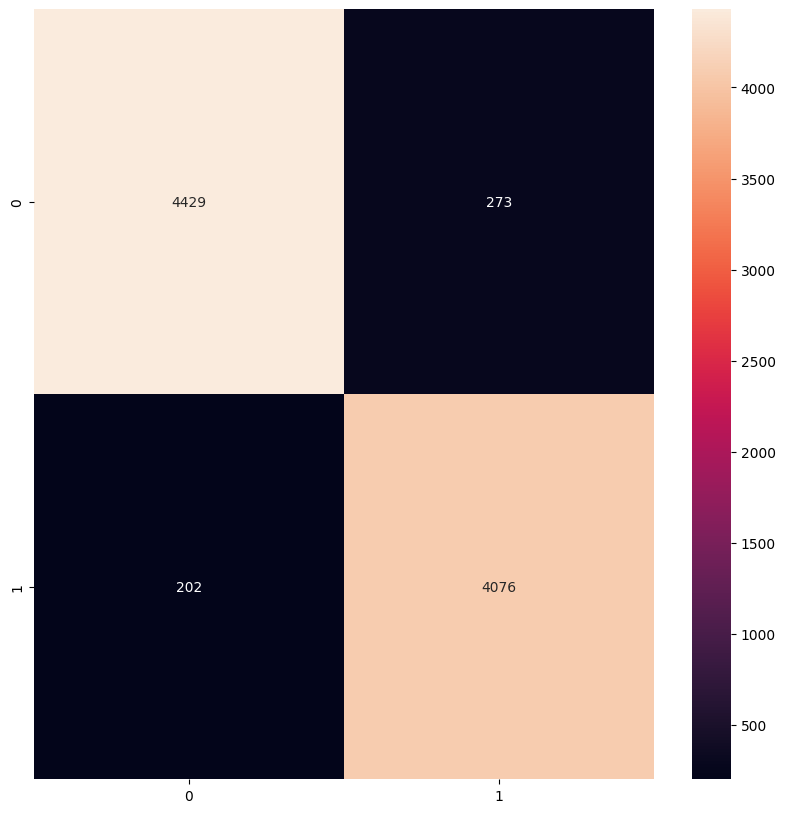

In [59]:
# Create and plot confusion matrix to compare predicted with actual value
cm = confusion_matrix(list(y_test_1), predicted_value)
plt.figure(figsize = (10, 10))
# Add heatmap according to the values within the confusion matrix
sns.heatmap(cm, annot = True,fmt='g')

### Approach II: Content (Using the text content to predict the target of a news article)

In [60]:
# Apply the 'preprocess' function to each element in the 'text' column of the DataFrame 'df'
df['clean_text'] = df['text'].apply(preprocess)

# Apply a lambda function to join the preprocessed tokens into a single string for each row
df['clean_joined_text'] = df['clean_text'].apply(lambda x: " ".join(x))

Use `wordclouds` package to build world clouds with the words from the content of fake and true news.

**True News:**

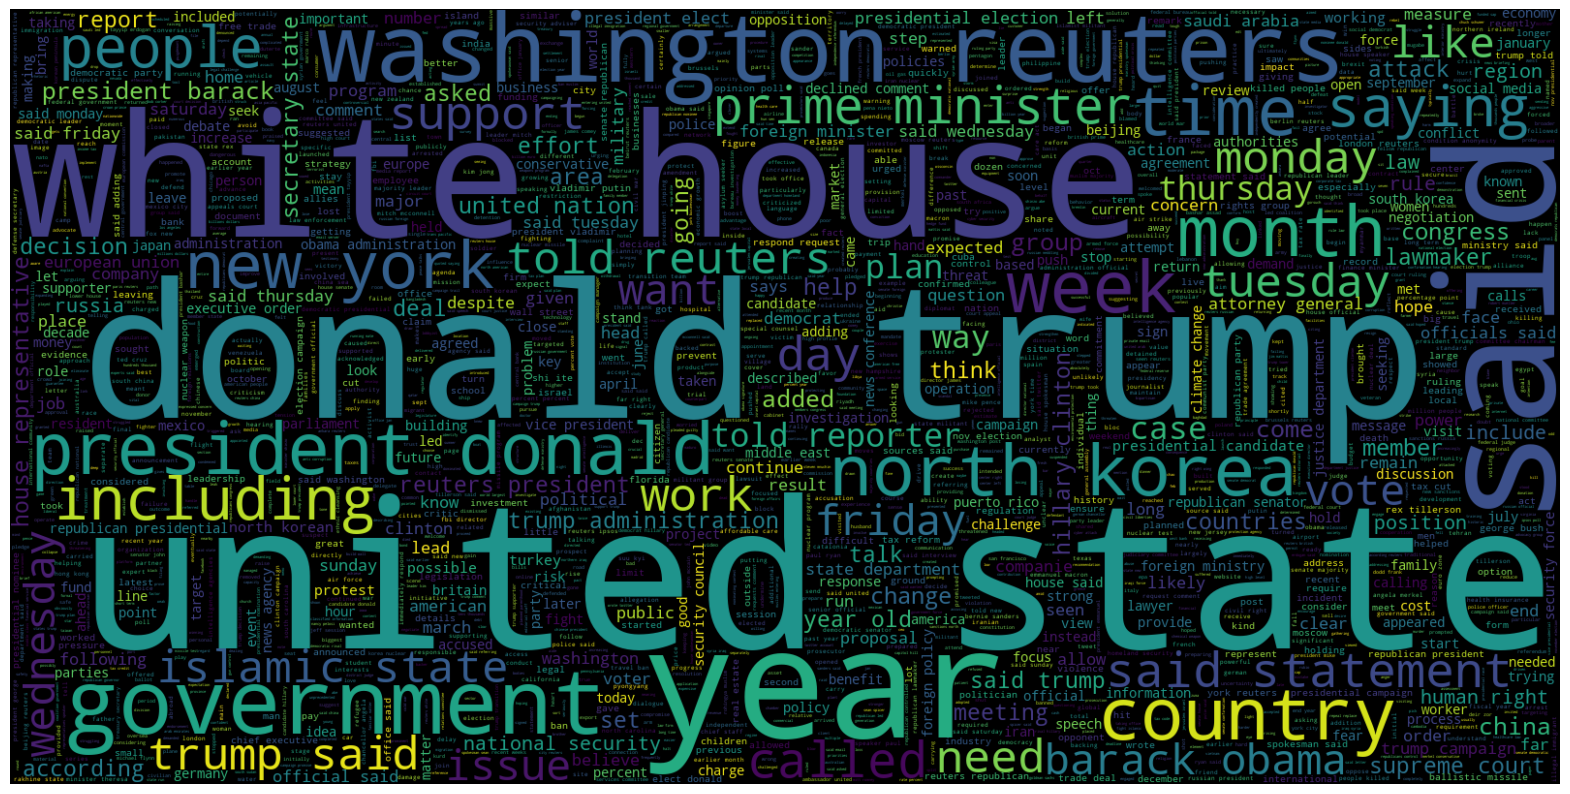

In [61]:
# Set the figure size
plt.figure(figsize=(20, 20))

# Generate a WordCloud for the 'clean_joined_text' column of rows where 'target' is 1
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))

# Display the WordCloud image using imshow
plt.imshow(wc, interpolation='bilinear')

# Remove x and y axes
plt.axis('off')

# Show the plot
plt.show()

**Fake News:**

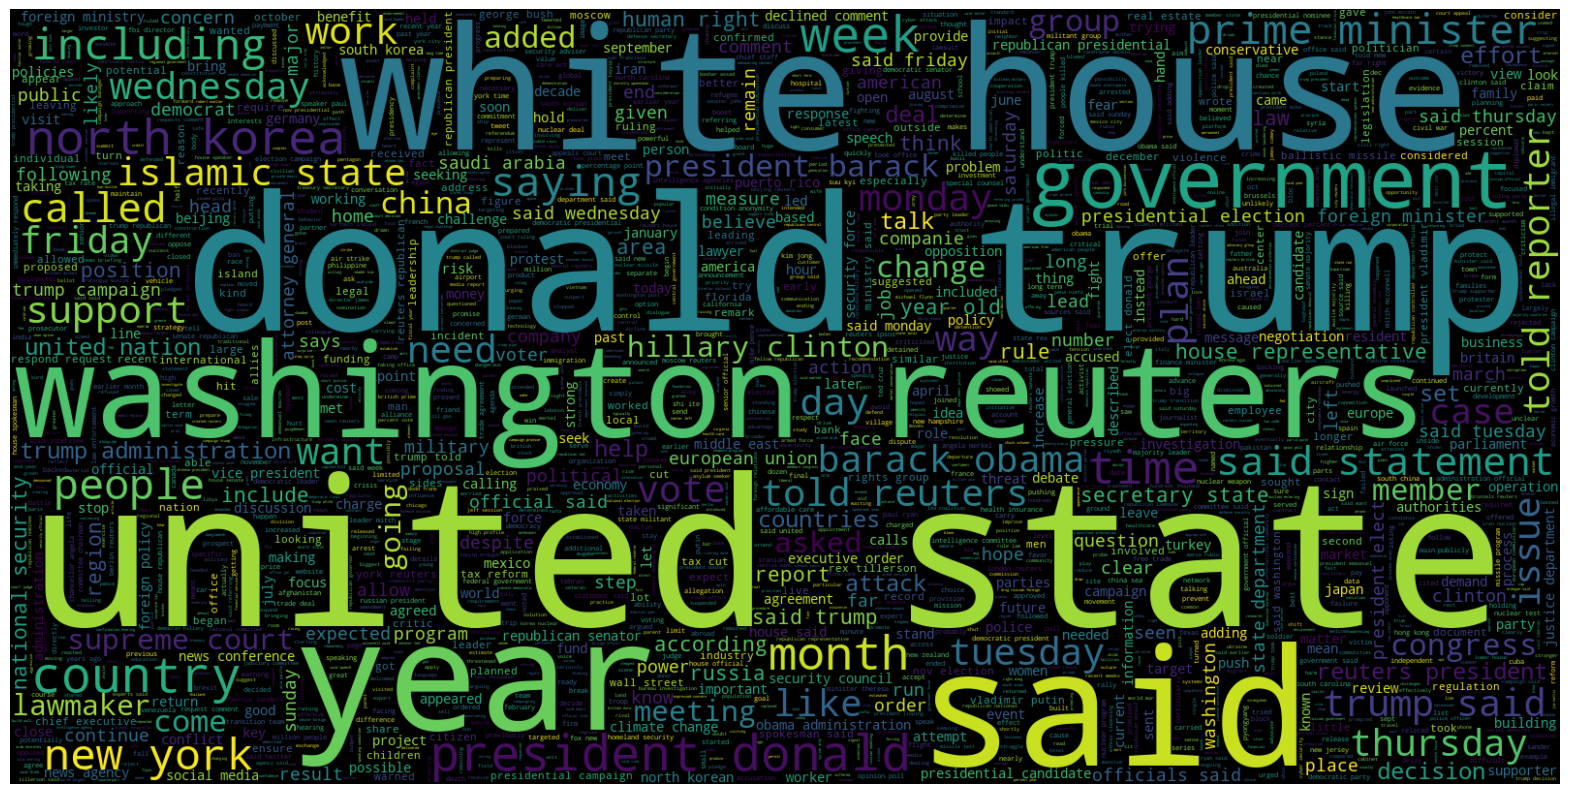

In [62]:
# Set the figure size
plt.figure(figsize=(20, 20))

# Generate a WordCloud for the 'clean_joined_text' column of rows where 'target' is 1
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))

# Display the WordCloud image using imshow
plt.imshow(wc, interpolation='bilinear')

# Remove x and y axes
plt.axis('off')

# Show the plot
plt.show()

In the following plot we print the number of words in a title and how often this number occurs. *Observation*: The longest text has 4,573 words and the text length that occurs the most (14,496 times) is in a range 100-199.

In [63]:
# Initialize a variable to track the maximum number of words
maxlen = -1

# Iterate over each document in the 'clean_joined_text' column of the DataFrame 'df'
for doc in df.clean_joined_text:
    # Tokenize the document into words using nltk
    tokens = nltk.word_tokenize(doc)
    
    # Check if the current document has more words than the current maximum
    if maxlen < len(tokens):
        maxlen = len(tokens)

# Print the maximum number of words in a news content
print("Maximum number of words in the text of a news article:", maxlen)

# Create a histogram using Plotly Express to visualize the distribution of the number of words in each document
fig = px.histogram(x=[len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins=50)

# Show the histogram
fig.show()

Maximum number of words in the text of a news article: 4573


Splitting the data set into testing and training.

In [64]:
# Train/ test split with in a 80/ 20 ratio
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

Prediction with Logistic Regression. *Observation*: The model based on Logistics performs extremely well with an accuracy of about 99.54%.

In [65]:
# Use LogisticRegression() as predictive modelling algorithm and fit model
model = LogisticRegression(C=2.5, max_iter=1000)
model.fit(X_vec_train, y_train)

# Do prediction
predicted_value = model.predict(X_vec_test)

# Get and print accuracy via "area under the curve" score
accuracy_value = roc_auc_score(y_test, predicted_value)
print(f"Accuracy Logistic Regression: {round(accuracy_value, 4)}")

Accuracy Logistic Regression: 0.9954


Show result in confusion matrix. *Observation*: In total we only missclassified 41 out of 8,980 news articles.

<Axes: >

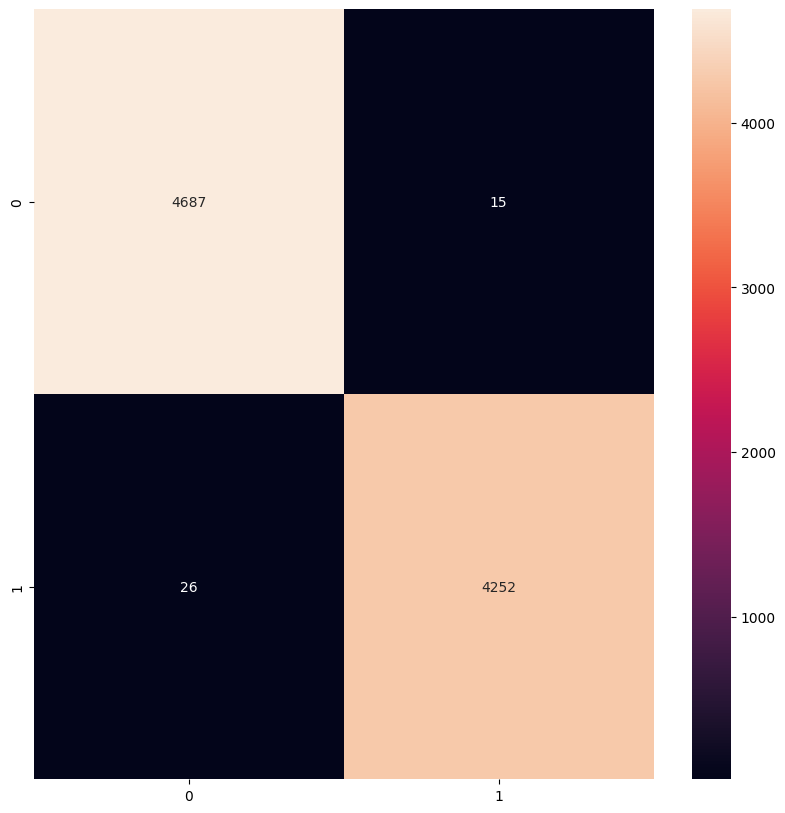

In [66]:
# Create and plot confusion matrix to compare predicted values with actual values
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
# Add heatmap according to the values within the confusion matrix
sns.heatmap(cm, annot = True,fmt='g')

### Approach III: Title + Content (Combination of Approach I and Approach II)

In [67]:
# Apply the 'preprocess' function to each element in the 'original' column of our data frame
df['clean_final'] = df['original'].apply(preprocess)

# Apply a lambda function to join the preprocessed tokens into a single string for each row
df['clean_joined_final'] = df['clean_final'].apply(lambda x: " ".join(x))

Splitting the data set into testing and training.

In [68]:
# Train/ test split with in a 80/ 20 ratio
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

Prediction with Logistic Regression. *Observation*: The model based on Logistics performs extremely well with an accuracy of about 99.67%.

In [69]:
# Use LogisticRegression() as predictive modelling algorithm and fit model
model = LogisticRegression(C=3, max_iter=1000)
model.fit(X_vec_train, y_train)

# Do prediction
predicted_value = model.predict(X_vec_test)

# Get and print accuracy via "area under curve" score
accuracy_value = roc_auc_score(y_test, predicted_value)
print(f"Accuracy Logistic Regression: {round(accuracy_value, 4)}")

Accuracy Logistic Regression: 0.9967


Show result in confusion matrix. *Observation*: In total we only missclassified 30 out of 8,980 news articles.

<Axes: >

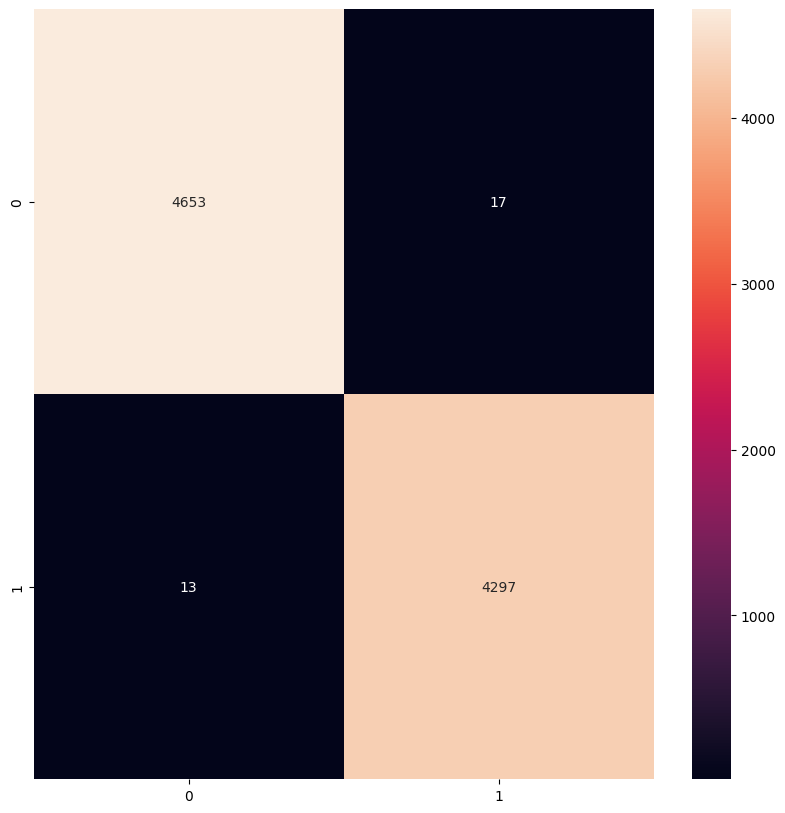

In [70]:
# Create and plot confusion matrix to compare predicted values with actual values
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))

# Add heatmap according to the values in the confusion matrix
sns.heatmap(cm, annot = True,fmt='g')

## E) Graphical Interface

Printing a few examples of fake and true news articles for testing purposes of the graphical interfaces.

In [71]:
# Find the first five rows where the 'target' column is 1
not_fake_examples = df[df['target'] == 1].head(3)

# Print the titles of the examples
print("Five Examples of Non-Fake News Titles:")
for index, example in not_fake_examples.iterrows():
    print(f"{index + 1}. {example['title']}")

print()

# Find the first three rows where the 'target' column is 0
fake_examples = df[df['target'] == 0].head(3)

# Print the titles of the examples
print("Three Examples of Fake News Titles:")
for index, example in fake_examples.iterrows():
    print(f"{index + 1}. {example['title']}")

Five Examples of Non-Fake News Titles:
1. As U.S. budget fight looms, Republicans flip their fiscal script
2. U.S. military to accept transgender recruits on Monday: Pentagon
3. Senior U.S. Republican senator: 'Let Mr. Mueller do his job'

Three Examples of Fake News Titles:
21418.  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
21419.  Drunk Bragging Trump Staffer Started Russian Collusion Investigation
21420.  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’


Pop-up Version: Using the `tkinter` library to make a pop-up window where we can type in a title and predict based on our trained model if that sounds like a title of a fake news or true news article.

In [72]:
# Function to analyze text and display result
def analyze_text():
    input_text = entry.get("1.0", "end-1c")  # Get text from the entry widget
    cleaned_text = " ".join(preprocess(input_text))  # Preprocess the input text
    vectorized_text = vec_train_1.transform([cleaned_text])  # Vectorize the preprocessed text
    prediction = model_1.predict(vectorized_text)  # Make a prediction
    result_label.config(text=f"Prediction: {'Fake' if prediction[0] == 0 else 'True'}")  # Display the prediction

# Create the main Tkinter window
window = tk.Tk()
window.title("Fake News Detector")

# Create and place GUI components
label = Label(window, text="Enter Text:")
label.pack()

entry = Text(window, height=10, width=50, wrap="word")
entry.pack()

analyze_button = Button(window, text="Analyze", command=analyze_text)
analyze_button.pack()

result_label = Label(window, text="Prediction: ")
result_label.pack()

# Start the Tkinter event loop
window.mainloop()

HTML/CSS Version: Using the `flask` library to make a pop-up window where we can type in a title and predict based on our trained model if that sounds like a title of a fake news or true news article.

In [73]:
# Create a Flask app and configure it to run with ngrok for exposing the app through a public URL
app = Flask(__name__)
run_with_ngrok(app)

# Define a text preprocessing function, removing English stopwords
def preprocess(text):
    stop_words = stopwords.words('english')
    result = [token for token in simple_preprocess(text) if token not in stop_words]
    return result

# Define the home route that renders the 'index.html' template
@app.route('/')
def home():
    return render_template('index.html')

# Define the analyze route that processes a POST request, analyzes text, and renders the result on the 'index.html' template
@app.route('/analyze', methods=['POST'])
def analyze():
    # Extract the input text from the POST request
    input_text = request.form['text']
    
    # Preprocess the input text by removing stopwords
    cleaned_text = " ".join(preprocess(input_text))
    
    # Transform the cleaned text using a pre-trained CountVectorizer
    vectorized_text = vec_train_1.transform([cleaned_text])
    
    # Make a prediction using a pre-trained Logistic Regression model
    prediction = model_1.predict(vectorized_text)
    
    # Determine the result based on the prediction
    result = 'Fake' if prediction[0] == 0 else 'True'
    
    # Render the 'index.html' template with the result and original input text
    return render_template('index.html', result=result, input_text=input_text)

# Run the Flask app if the script is executed directly
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


 * Running on http://a62b-23-128-112-23.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [15/Nov/2023 19:52:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2023 19:52:23] "GET /static/FLPoly_Logo.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Nov/2023 19:52:23] "GET /static/FloridaPoly-IST164.jpg HTTP/1.1" 304 -
127.0.0.1 - - [15/Nov/2023 19:52:57] "POST /analyze HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2023 19:52:57] "GET /static/FLPoly_Logo.png HTTP/1.1" 304 -
127.0.0.1 - - [15/Nov/2023 19:52:57] "GET /static/FloridaPoly-IST164.jpg HTTP/1.1" 304 -
